In [746]:
import pandas as pd
import pydot, pydotplus, graphviz
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from keras.constraints import non_neg
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import classification_report

import numpy as np
from keras.layers import Embedding, Reshape, Concatenate
from keras.models import Sequential
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
import math


%matplotlib inline

### Train subset

In [517]:
dataset_ = pd.read_csv("/Users/ilonakulikovskikh/code/data/idg_ilona/case2/case2_train.csv",sep=',')

In [518]:
print(dataset_.head())
dataset = dataset_[['cmpd_id','target_id','pKd']]
print(dataset.head())

   Unnamed: 0        cmpd_id target_id       pKd  CHEMBL360138  CHEMBL3091726  \
0           1  CHEMBL1232461    P25440  7.000000      0.616438       0.611765   
1           2  CHEMBL1232461    O60885  7.187087      0.616438       0.611765   
2          10  CHEMBL3645119    P52333  8.537602      0.481481       0.579545   
3          11  CHEMBL3645119    P43405  7.008774      0.481481       0.579545   
4          13  CHEMBL3645119    P23458  8.173925      0.481481       0.579545   

   CHEMBL584293  CHEMBL3605998  CHEMBL2435408  CHEMBL3752448   ...    P07306  \
0      0.500000       0.520000       0.493506       0.548780   ...     0.101   
1      0.500000       0.520000       0.493506       0.548780   ...     0.026   
2      0.609195       0.657143       0.602740       0.767123   ...     0.097   
3      0.609195       0.657143       0.602740       0.767123   ...     0.126   
4      0.609195       0.657143       0.602740       0.767123   ...     0.088   

   Q9Z1T6  P01127  P19838  Q96A5

In [803]:
n_cmpds = len(dataset.cmpd_id.unique())
n_targets = len(dataset.target_id.unique())
print(n_cmpds, n_targets)

789 442


In [520]:
dataset.cmpd_id = dataset.cmpd_id.astype('category').cat.codes.values
dataset.target_id = dataset.target_id.astype('category').cat.codes.values

In [521]:
# Get summary statistics
dataset['pKd'].describe()

count    13786.000000
mean         5.506083
std          0.989398
min          1.806875
25%          5.000000
50%          5.000000
75%          5.698970
max         12.602060
Name: pKd, dtype: float64

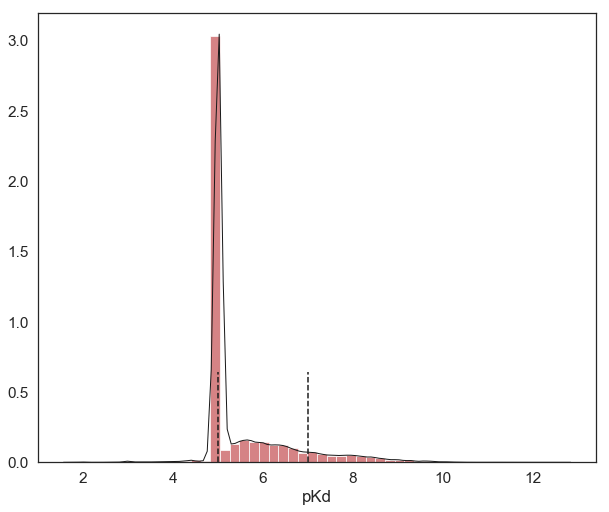

In [522]:

sns.set(rc={'figure.figsize':(10,8.27)})

sns.set_color_codes()
sns.set(style='white', font_scale=1.4)


# Display distribution 
sns.distplot(dataset['pKd'].fillna(dataset['pKd'].median()),
            kde_kws={"color": "k", "lw": 1},
            hist_kws={"alpha": 0.7, "color": "r"})
plt.axvline(7, 0, 0.2, color="k", linestyle="--")
plt.axvline(5, 0, 0.2, color="k", linestyle="--")

### Validation subset

   Unnamed: 0        cmpd_id target_id       pKd  CHEMBL360138  CHEMBL3091726  \
0           4  CHEMBL3669127    P63085  5.031517      0.518987       0.654762   
1           5  CHEMBL3669127    P47811  5.346787      0.518987       0.654762   
2           6  CHEMBL2386796    Q9UM73  8.619789      0.625000       0.536082   
3           7  CHEMBL3605998    P11103  7.522879      0.440000       0.607595   
4           8  CHEMBL3669571    O43614  6.818156      0.460526       0.604938   

   CHEMBL584293  CHEMBL3605998  CHEMBL2435408  CHEMBL3752448   ...    P07306  \
0      0.538462       0.567568       0.560000       0.573171   ...     0.210   
1      0.538462       0.567568       0.560000       0.573171   ...     0.017   
2      0.785714       0.575000       0.567901       0.674699   ...     0.061   
3      0.560976       1.000000       0.750000       0.671429   ...     0.108   
4      0.578313       0.754098       0.963636       0.643836   ...     0.087   

   Q9Z1T6  P01127  P19838  Q96A5

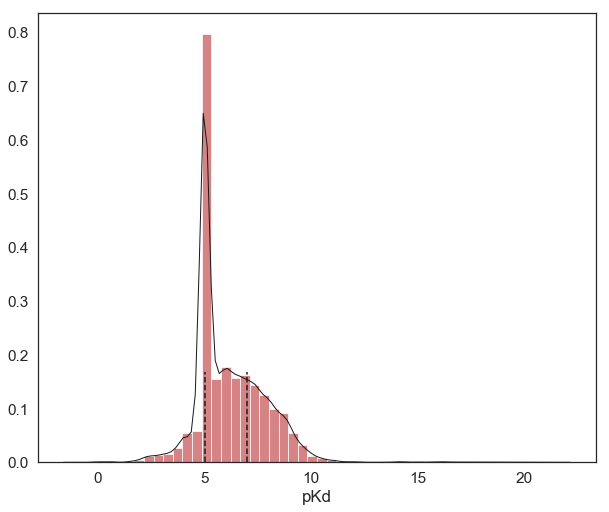

In [801]:
dataset__ = pd.read_csv("/Users/ilonakulikovskikh/code/data/idg_ilona/case2/case2_validation.csv",sep=',')

print(dataset__.head())
dataset_val = dataset__[['cmpd_id','target_id','pKd']]
print(dataset_val.head())

n_cmpds_val = len(dataset_val.cmpd_id.unique())
n_targets_val = len(dataset_val.target_id.unique())
print(n_cmpds_val, n_targets_val)

dataset_val.cmpd_id = dataset_val.cmpd_id.astype('category').cat.codes.values
dataset_val.target_id = dataset_val.target_id.astype('category').cat.codes.values

dataset_val.cmpd_id = dataset_val.cmpd_id.astype('category').cat.codes.values
dataset_val.target_id = dataset_val.target_id.astype('category').cat.codes.values

# Get summary statistics
dataset_val['pKd'].describe()


sns.set(rc={'figure.figsize':(10,8.27)})

sns.set_color_codes()
sns.set(style='white', font_scale=1.4)


# Display distribution 
sns.distplot(dataset_val['pKd'].fillna(dataset_val['pKd'].median()),
            kde_kws={"color": "k", "lw": 1},
            hist_kws={"alpha": 0.7, "color": "r"})
plt.axvline(7, 0, 0.2, color="k", linestyle="--")
plt.axvline(5, 0, 0.2, color="k", linestyle="--")

## Approach 1: Deep learning

A simple implementation of matrix factorization for collaborative filtering expressed as a Keras Sequential model.



In [614]:
# Check the samples info
print(dataset.info())
print(dataset_val.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13786 entries, 0 to 13785
Data columns (total 3 columns):
cmpd_id      13786 non-null int16
target_id    13786 non-null int16
pKd          13786 non-null float64
dtypes: float64(1), int16(2)
memory usage: 161.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40159 entries, 0 to 40158
Data columns (total 3 columns):
cmpd_id      40159 non-null int16
target_id    40159 non-null int16
pKd          40159 non-null float64
dtypes: float64(1), int16(2)
memory usage: 470.7 KB
None


In [798]:
print(max_cmpdid)
print(max_targetid)
n_cmpd_id, n_target_id = len(dataset.cmpd_id.unique()), len(dataset.target_id.unique())



788
441
789 442


In [741]:
# Create training set
n_cmpd_id, n_target_id = len(dataset.cmpd_id.unique()), len(dataset.target_id.unique())
n_latent_factors = 30

max_cmpdid = dataset['cmpd_id'].drop_duplicates().max()
max_targetid = dataset['target_id'].drop_duplicates().max()
print(max_cmpdid)
print(max_targetid)

import random
RNG_SEED = random.seed()
shuffled_dataset = dataset.sample(frac=1., random_state=RNG_SEED)

interactions = shuffled_dataset['pKd'].values
print ('pKd:', interactions, ', shape =', interactions.shape)

cmpds = shuffled_dataset['cmpd_id'].values
print ('Cmpd:', cmpds, ', shape =', cmpds.shape)

targets = shuffled_dataset['target_id'].values
print ('Target:', targets, ', shape =', targets.shape)


pKd: [6.24412514 5.         5.         ... 6.25963731 5.         5.        ] , shape = (13786,)
Cmpd: [360 739  19 ... 740 723 376] , shape = (13786,)
Target: [ 96 430 197 ... 224  24 377] , shape = (13786,)


In [743]:
# Define model
target_id_input = keras.layers.Input(shape=[1],name='target_id')
target_id_embedding = keras.layers.Embedding(n_target_id + 1, n_latent_factors, name='Target-Embedding', embeddings_constraint=non_neg())(target_id_input)
target_id_vec = keras.layers.Flatten(name='FlattenTarget')(target_id_embedding)

cmpd_id_input = keras.layers.Input(shape=[1],name='cmpd_id')
cmpd_id_vec = keras.layers.Flatten(name='FlattenCmpd')(keras.layers.Embedding(n_cmpd_id + 1, n_latent_factors,name='Cmpd-Embedding', embeddings_constraint=non_neg())(cmpd_id_input))

prod = keras.layers.dot([target_id_vec, cmpd_id_vec], axes=1, normalize=False) 

model = keras.Model([cmpd_id_input, target_id_input], prod)

model.compile(loss='mse', optimizer='adam')


In [744]:
# Callbacks monitor the validation loss
# Save the model weights each time the validation loss has improved
callbacks = [EarlyStopping('val_loss', patience=2), 
             ModelCheckpoint('weights.h5', save_best_only=True)]

# Use 30 epochs, 90% training data, 10% validation data 
history = model.fit([cmpds, targets], interactions, nb_epoch=300, validation_split=.1, verbose=2, callbacks=callbacks)


Train on 12407 samples, validate on 1379 samples
Epoch 1/300
 - 1s - loss: 26.5079 - val_loss: 16.9221
Epoch 2/300
 - 0s - loss: 9.2728 - val_loss: 4.4752
Epoch 3/300
 - 0s - loss: 4.1223 - val_loss: 3.6692
Epoch 4/300
 - 0s - loss: 3.5778 - val_loss: 3.4883
Epoch 5/300
 - 0s - loss: 3.1704 - val_loss: 3.3215
Epoch 6/300
 - 0s - loss: 2.7781 - val_loss: 3.1630
Epoch 7/300
 - 0s - loss: 2.4150 - val_loss: 3.0084
Epoch 8/300
 - 0s - loss: 2.0874 - val_loss: 2.8639
Epoch 9/300
 - 0s - loss: 1.8052 - val_loss: 2.7380
Epoch 10/300
 - 0s - loss: 1.5672 - val_loss: 2.6109
Epoch 11/300
 - 0s - loss: 1.3684 - val_loss: 2.4992
Epoch 12/300
 - 0s - loss: 1.2026 - val_loss: 2.4039
Epoch 13/300
 - 0s - loss: 1.0646 - val_loss: 2.3200
Epoch 14/300
 - 0s - loss: 0.9494 - val_loss: 2.2580
Epoch 15/300
 - 0s - loss: 0.8531 - val_loss: 2.1975
Epoch 16/300
 - 0s - loss: 0.7742 - val_loss: 2.1516
Epoch 17/300
 - 0s - loss: 0.7093 - val_loss: 2.1044
Epoch 18/300
 - 0s - loss: 0.6570 - val_loss: 2.0702
Epoc

In [710]:
# Load weights
model.load_weights('weights.h5')

# Show the best validation RMSE
min_val_loss, idx = min((val, idx) for (idx, val) in enumerate(history.history['val_loss']))
print ('Minimum RMSE at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(math.sqrt(min_val_loss)))


Minimum RMSE at epoch 231 = 1.4598


In [799]:
TEST_CMPD = 800 

# Training subset
print(dataset[dataset['cmpd_id'] == TEST_CMPD])

def predict_interations(cmpd_id, target_id):
    return model.predict([np.array([cmpd_id]), np.array([target_id])])[0][0]

cmpd_interations = dataset[dataset['cmpd_id'] == TEST_CMPD][['cmpd_id', 'target_id', 'pKd']]
cmpd_interations['prediction'] = cmpd_interations.apply(lambda x: predict_interations(TEST_CMPD, x['target_id']), axis=1)

print(cmpd_interations)

Empty DataFrame
Columns: [cmpd_id, target_id, pKd]
Index: []


ValueError: Cannot set a frame with no defined index and a value that cannot be converted to a Series

In [800]:
TEST_CMPD = 800


# Validation subset
print(dataset_val[dataset_val['cmpd_id'] == TEST_CMPD])

def predict_interations(cmpd_id, target_id):
    return model.predict([np.array([cmpd_id]), np.array([target_id])])[0][0]

cmpd_interations = dataset_val[dataset_val['cmpd_id'] == TEST_CMPD][['cmpd_id', 'target_id', 'pKd']]
cmpd_interations['prediction'] = cmpd_interations.apply(lambda x: predict_interations(TEST_CMPD, x['target_id']), axis=1)

print(cmpd_interations)

       cmpd_id  target_id       pKd
36118      800       1202  7.349984
36119      800        259  9.698970


InvalidArgumentError: indices[0,0] = 1202 is not in [0, 443)
	 [[{{node Target-Embedding_18/embedding_lookup}}]]

In [766]:
cmpd_interations.apply(lambda x: predict_interations(TEST_CMPD, x['target_id']), axis=1)

InvalidArgumentError: indices[0,0] = 1400 is not in [0, 443)
	 [[{{node Target-Embedding_18/embedding_lookup}}]]